# ComputeFest 2019
## Model Agnostic Methods for Interpretability and Fairness

### Harvard IACS

- Pavlos Protopapas
- Paul Blankley, Camilo Fosco, Ryan Janssen

Main student notebook for the interpretability and fairness workshop. Here, you will analyze machine learning models with interesting interpretability tools and explore fairness metrics to measure discrimination.

In [1]:
### Imports

# Native
import random
import warnings
import itertools

# The usual suspects
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Deep learning
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions

# Sklearn and skimage
from sklearn.neighbors import BallTree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, auc, f1_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from skimage.segmentation import mark_boundaries

# LIME 
from lime import lime_text
from lime import lime_image
from lime.lime_tabular import LimeTabularExplainer
from lime.lime_text import LimeTextExplainer

# Shapley values
import shap

# Custom
import interp

# AIF360 imports
from aif360.algorithms.preprocessing import OptimPreproc
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

sns.set_palette('muted', color_codes=True)
%matplotlib inline

Using TensorFlow backend.


AttributeError: module 'snappy' has no attribute 'compress'

<br>
<br>
<br>

# Step 0: Download the data and perform EDA

For this notebook, we'll using the LendingClub dataset.  This data covers LendingClub's open peer-to-peer lending data from 2012 to 2018.  The dataset contains features about the borrower, and each row represents a loan.  We've done a bit of pre-cleaning for this version.

[Click here to download the dataset](https://drive.google.com/file/d/1yVUnuSA19CHyLbeyfCkunp5AGKzyBKLx/view?usp=sharing).  Be sure to save it in the data/ directory in the repo.

Then, run the cell below to see if you import it:

In [2]:
# Import cleaned data
df = pd.read_csv('../data/loans_data.csv')
print(f'Import successful!  We have {len(df)} rows.')
df.head()

Import successful!  We have 805148 rows.


,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,emp_length,home_ownership,verification_status,zip_code,term,initial_list_status,disbursement_method,application_type,loan_status,age_of_cr_line
0,5000.0,0.1065,24000.0,27.65,0.0,735.0,1.0,34.446551,70.816146,3.0,...,10+ years,RENT,Verified,860xx,36,f,Cash,Individual,1,34.0
1,2500.0,0.1527,30000.0,1.00,0.0,740.0,5.0,34.446551,70.816146,3.0,...,< 1 year,RENT,Source Verified,309xx,60,f,Cash,Individual,0,20.0
2,2400.0,0.1596,12252.0,8.72,0.0,735.0,2.0,34.446551,70.816146,2.0,...,10+ years,RENT,Not Verified,606xx,36,f,Cash,Individual,1,18.0
3,10000.0,0.1349,49200.0,20.00,0.0,690.0,1.0,35.000000,70.816146,10.0,...,10+ years,RENT,Source Verified,917xx,36,f,Cash,Individual,1,23.0
4,3000.0,0.1269,80000.0,17.94,0.0,695.0,0.0,38.000000,70.816146,15.0,...,1 year,RENT,Source Verified,972xx,60,f,Cash,Individual,1,23.0


## Exercise 0:

Find the distribution of `fico_range_low` for defaulted loans and paid back loans.  Are these distributions different? Do they match your expectations?
<br>
- HINT: The response column is `loan_status` with a 1 = paid back loan and 0 = defaulted loan 

In [1]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------



<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Step 1: Build our model

### Seperate out into train and test

Our objective is to build a model that predicts if someone will default on a loan.  We've supplied a set of columns to use for the predictive model.  

In [4]:
# One hot encoding and subset into train/test 
quant_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',\
              'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec',\
              'revol_bal', 'revol_util', 'total_acc', 'acc_now_delinq', 'tot_coll_amt',\
              'tot_cur_bal', 'tax_liens', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',\
              'age_of_cr_line', 'installment']

cat_cols = ['grade','emp_length', 'home_ownership','verification_status', 'term', 'initial_list_status',\
            'disbursement_method', 'application_type']

other_cols = ['zip_code']
response_col = 'loan_status'

df_x = pd.get_dummies(df[quant_cols+cat_cols], drop_first=False, columns=cat_cols)
df_y = df[response_col]

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

### Model plotting functions 
These are some functions we commonly use to plot model results. 

In [5]:
def plot_confusion_matrix(y_vals, y_preds, classes=['Negative', 'Positive'], normalize=False, \
                          title='Confusion matrix', cmap=plt.cm.Reds, ax=None):
    """ This function prints and plots the confusion matrix. Normalization can be applied 
    by setting `normalize=True`.
    -------
    Args:
        y_vals (iterable): The true y values of the classifier 
        y_preds (iterable): The predicted y values from the classifier
        classes (iter): iterable with the class names in it. Default: [Negative, Positive]
        normalize (bool): to normalize the confusion matrix or not. Default: False
        title (str): the title of the plot. Default: 'Confusion Matrix'
        cmap (matplotlib.cm): a colormap to color the confusion matrix with 
        ax (plt.Axes): axis to plot on 
    -------
    Returns:
        (plt.Axes)
    """
    cm = confusion_matrix(y_vals, y_preds)

    if ax is None:
        ax = plt.axes()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    PCM = ax.get_children()[9]
    plt.colorbar(PCM, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="grey" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()
    return ax

def plot_roc(tfpr, ttpr, fpr=None, tpr=None, grid=True, ax=None):
    """ Function to plot the roc curve for a model given the test and (maybe) training tpr and fpr
    ---------
    Args:
        tfpr (np.array): the test false positive rates 
        ttpr (np.array): the test true positive rates 
        fpr (np.array): the train false positive rates 
        tpr (np.array): the train true positive rates 
        grid (bool): plot grid?
        ax (plt.Axes): axis to plot on 
    ---------
    Returns:
        (plt.Axes)
    """ 
    train = tpr is not None and fpr is not None

    if ax is None:
        ax = plt.axes()

    lw = 2
    if train:
        ax.plot(fpr, tpr, color='#A25100',
             lw=lw, label='ROC curve - train', alpha=0.4)
    ax.plot(tfpr, ttpr, color='#A20000',
             lw=lw, label='ROC curve - test', alpha=0.4)
    ax.plot(np.linspace(0,1,10), np.linspace(0,1,10), '--', color='grey', alpha=0.4)
    ax.set_xlim([-0.025, 1.0])
    ax.set_ylim([0.0, 1.025])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc="lower right")
    if grid:
        ax.grid(color='grey', zorder=1, alpha=.15)
    sns.despine(offset=0, trim=False)
    return ax


### Fit model

Let's fit a model to the LendingClub data and see how well we do.  

We will use a Random Forest because it is a high-capacity model which cannot be explained trivially. 


Accuracy Train: 0.9977; Accuracy Test: 0.7959
AUC train: 1.0; AUC test: 0.6856


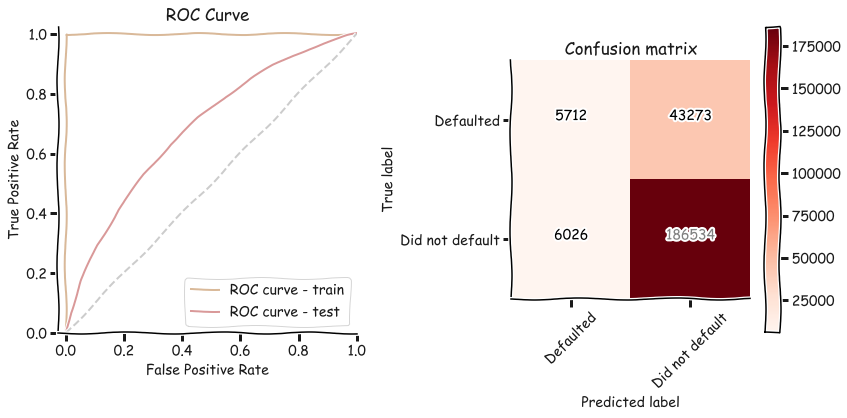

In [6]:
model = RandomForestClassifier(n_estimators=25, max_depth=None, \
                               random_state=42).fit(x_train, y_train)

# Calc AUC and ROC curve + CM
fpr, tpr, _ = roc_curve(y_train, model.predict_proba(x_train)[:, 1], pos_label=1)
auc_train = auc(fpr.reshape(-1, 1), tpr.reshape(-1, 1))
tfpr, ttpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:, 1], pos_label=1)
auc_test = auc(tfpr.reshape(-1, 1), ttpr.reshape(-1, 1))

print(f'Accuracy Train: {round(model.score(x_train, y_train),4)};',\
      f'Accuracy Test: {round(model.score(x_test, y_test),4)}')
print(f'AUC train: {round(auc_train,4)}; AUC test: {round(auc_test,4)}')

with plt.xkcd():   
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
    plot_roc(tfpr,ttpr,fpr,tpr, ax=ax1)
    plot_confusion_matrix(y_test, model.predict(x_test), classes=['Defaulted','Did not default'], ax=ax2)
    plt.tight_layout()
    plt.show()

### Exercise 1: Plot the feature importances for the random forest model. 
- HINT: sklearn ensemble models have an attribute `.feature_importances_` which may be useful

As always, feel free to google around to find examples! 

We can look at feature importances for the model because it's a tree-based ensemble.  Feature importances are good for a quick look but they can sometimes be [misleading](https://explained.ai/rf-importance/index.html).  

Even if the calculated feature importances are faithful to the model's structure, we still do not know the importance of certain features for *individual* observations or *sub-groups* of observations.

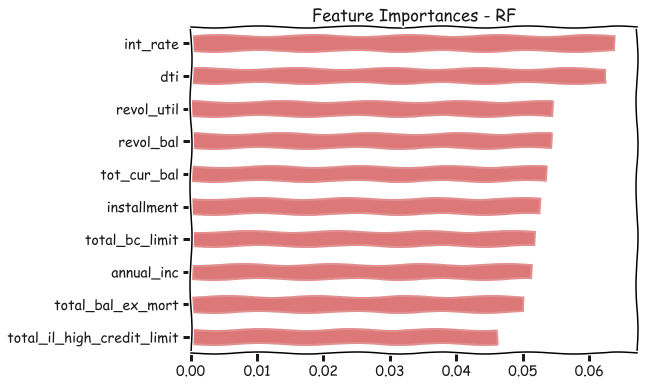

In [7]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------

# Code for answers section
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(8,6))
    feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
    ax = feat_importances.nlargest(10).sort_values().plot(kind='barh', color='r', alpha=0.6, ax=ax)
    ax.set_title('Feature Importances - RF');

### Exercise 2: Build model prediction for observation 95329.
- HINT: you can access an observation by number using `.values` on a pandas dataframe with numpy indexing `[row, col]`

In [2]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------



<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Step 2: Local Perturbations

We are going to focus on [LIME (Local Interperetable Model-agnostic Explainations)](https://github.com/marcotcr/lime) for our local interperatability section.  

LIME works by making a linear approximation to the model's decision boundary at the specified point and using the coefficients of the linear approximation to explain the model's behavior at that point.  This means LIME is pretty fast, but it also means the results are not 100% stable.  

LIME builds its linear approximation by perturbing points around the chosen point and feeding them into a regression model to classify which side of the model's decision boundary they are on.  Once the linear approximation is made (accuracy is not a metric that is quantified in the LIME package thus far), the coefficients of the linear approximation are used to explain the model's behavior at that point.  

In [9]:
# Make the LIME explainer with training data
explainer = LimeTabularExplainer(x_train.values, feature_names=x_train.columns, training_labels=y_train,\
                                 class_names=['Defaulted', 'Did not default'], kernel_width=4, random_state=42)

### Exercise 3: Build LIME interpretation for observation 95329.
- HINT: you can look at [LIME examples](https://github.com/marcotcr/lime) and remember to `show_in_notebook` for nice visualization.

In [3]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------



### LIME prediction
- This is for a single observation 
- LIME approximates the decision boundary of the model with a line 

This example shows our model making a reasonable, but worrisome decision.  Although the prediction is Default, and based on our intuition about loans we would predict the same result, the way the model arrives at its conslusion is problematic.  Features like a high interest rate and a high debt-to-income ratio are both indicative of a *higher* chance of paying back the loan.  

This is counter intuiative because we would not normally expect someone who already has a lot of debt to pay back a loan with higher probability than someone with a low interest rate loan without much debt. This requires further investigation.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
# Step 3: Decision Boundaries

We're going to look at bivariate (2D) and univariate (1D) decision boundaries in this step.

### Bivariate decision boundary plot

This plot uses the ranges of two features and the closest existing point to each pair of feature values to make the 2D decision boundary. The plot gives us a good approximation to the model's decision boundary between the two features.

We can use this plot to check if the model's decision boundary looks as we would expect, and see where our point lies. 

In [11]:
# Helper functions
def plot_decision_boundary_2d(df_x, model, col1, col2, title, df_y=None, 
                              samples=True, save_path=None, ax=None):
    """ This function plots the approximate decision boundary in the 2D space 
    of the columns specified. It works by building a KD-Tree of the points made 
    by the values of the specified columns and then looking up the closest point 
    to the values we create on our interval for plotting. We use the feature values 
    of the closest point as the feature values of the columns not being plotted 
    when determining the decision boundary.  So to clarify this is an ESTIMATE. 
    We also plot the actual points and decisions so the user can see where the estimate fails.
    ------
    Args: df_x; pandas dataframe with the x data
          model; any valid model with a .predict_proba method 
          col1; string representing the first column (x axis of the plot)
          col2; string representing the second column (y axis of the plot)
          title; string that is the title of the plot 
          save_path; path to save the figure to. does not save if left on default which 
                is None. Note: you have to include what you want to save it as with the extension 
                e.g. save_path='../reports/decision_boundary.png'
          df_y; either numpy array or panads series with y values defaults to None 
                and real points are not included  
    ------
    Returns: None 
    """
    if ax is None:
        ax = plt.axes()
        
    # DataFrame top numpy transition 
    x = df_x.values
    c1 = list(df_x.columns).index(col1)
    c2 = list(df_x.columns).index(col2)
    
    # Make the kd tree
    kdtree = BallTree(x[:,[c1,c2]], leaf_size=400)
    
    # Create mesh
    # Interval of points for feature 1
    min0 = x[:,c1].min()
    max0 = x[:,c1].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for feature 2
    min1 = x[:,c2].min()
    max1 = x[:,c2].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    idxs = kdtree.query(xx,k=1,return_distance=False)
    nearest_points = x[idxs.ravel()]
    nearest_points[:,c1] = x1.ravel()
    nearest_points[:,c2] = x2.ravel()

    # Predict on mesh of points
    yy = model.predict_proba(nearest_points)[:,0]
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    levs = np.linspace(0,.7,50) # Bias the top because green is less distinct than red
    ax.contourf(x1, x2, yy, cmap='RdYlGn_r', alpha=1, levels=levs)

    # Plot scatter plot of data
    if df_y is not None and samples is True:
        y_true = np.array(df_y).reshape(-1,)
        ax.scatter(x[:,c1], x[:,c2], c='grey', label='Samples', zorder=1.1, alpha=0.1)
            
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    return ax

## How is our model looking?

Not good! The test set has reasonable 2D decision boundaries, but the training set looks like it is hopelessly overfitting. 

Next, we will take a look at two important features in our LIME analysis of point 95329.

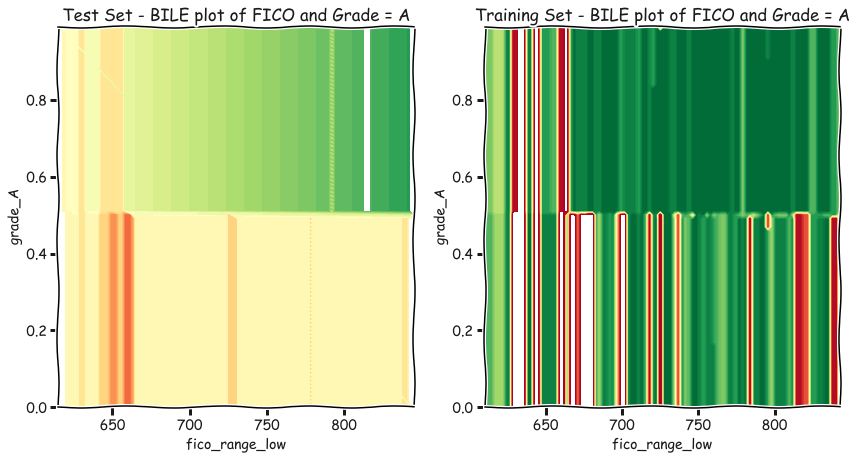

In [12]:
with plt.xkcd():
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,7))
    plot_decision_boundary_2d(x_test, model, 'fico_range_low', 'grade_A', \
                              'Test Set - BILE plot of FICO and Grade = A', ax=ax1);
    plot_decision_boundary_2d(x_train, model, 'fico_range_low', 'grade_A', \
                              'Training Set - BILE plot of FICO and Grade = A', ax=ax2);
    plt.show()

### Exercise 4: Make a BILE plot with interest rate and DTI ratio 
- HINT: Filter the dataframe to only plot rows with DTI below 70 (we want to see most of the data, not outliers)

In [4]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------



### LICE plots! 


- Have you noticed there are several features that always seem to come up in the most important in this model?
- Let's have a closer look at some of those featues using (Local) [ICE (Individual Conditional Expectation)](https://christophm.github.io/interpretable-ml-book/ice.html) plots.

LICE plots give us a picture of how a specific point behaves when one variable is moved univariately. Look at these plots and see what they tell you aboout the model's behavior. Does the behavior match your intutition?

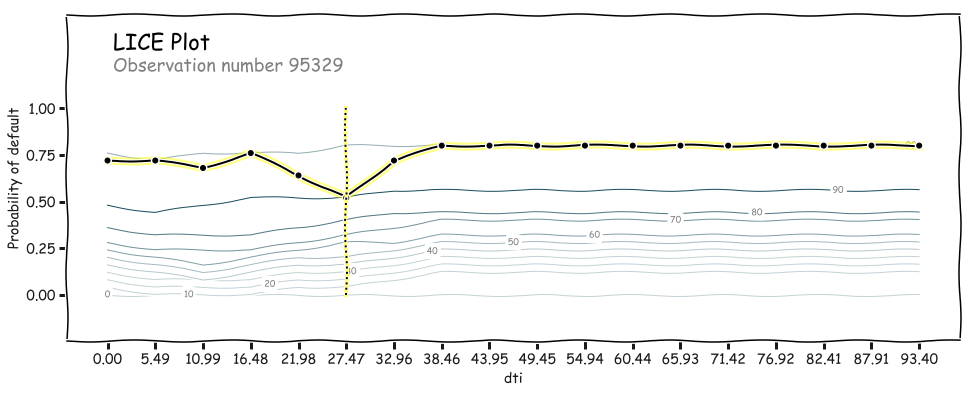

In [14]:
obs = 95329
lice_data = pd.concat([df_x.sample(10000, random_state=21), df_x.iloc[obs,:].to_frame().T], sort=False)

with plt.xkcd():
    interp.Lice.plot_lice(lice_data, model, 'dti', obs);

### Exercise 5: Make a LICE plot with the interest rate feature for point 95329
- HINT: You can use the `lice_data` variable from the previous plot to avoid resampling data

In [5]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------



### Even more interpretability!

We will look at input gradients and Shapley values (although we only run Shapley values due to time) 

Input gradients use finite difference to find the derivative of the model w.r.t the input column while keeping all other features the same.  This measures the univariate impact of each feature for a specific observation.  We can get another mathematical viewpoint into the model's decision at a point and cross-reference with LIME.

#### Input gradients
- Relatively fast to run for single points
- Good mathematical basis
- Intuiative, but not a complete explaination 

#### Shapley values
 - [Shapley values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) are the gold standard in model interperatability.
 - They are based on a game theoretic approach to feature influence, and they are the only method with firm mathematical foundations.
 - Why don't we just always use them? They are *really* expensive computationally. 
 - [Here](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) is a fantastic summary of Shapley values!

---------------------------------------------

### Shapley Values:

The visualization below explains which features influenced the model toward its final conclusion based on their marginal contribution to the model's output.

In [16]:
shap.initjs()
shap_data = pd.concat([df_x.sample(10, random_state=21), df_x.iloc[obs,:].to_frame().T], sort=False)
predict_fn = lambda x: model.predict_proba(x)[:,1]

# Create the KernelEstimator and sample
shap_exp = shap.KernelExplainer(predict_fn, shap_data)
shap_values = shap_exp.shap_values(shap_data)

# visualize the first prediction's explanation
display(shap.force_plot(shap_exp.expected_value, shap_values[-1,:], df_x.iloc[obs,:]))

100%|██████████| 11/11 [00:03<00:00,  3.18it/s]


<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Bonus Step: LIME in the wild

Real world problems often involve data outside of the nice tabular format like we used in this workshop.  Let's run through two quick examples with different data types.  

### Images

- Who doesn't love a deep learning example?!
- NOTE: This was taken from the [LIME official tutorials](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb) and the next cell will take 1 - 2 minutes to run depending on your hardware. 


('n02133161', 'American_black_bear', 0.63716)
('n02105056', 'groenendael', 0.031818103)
('n02104365', 'schipperke', 0.029944422)
('n01883070', 'wombat', 0.028509434)
('n01877812', 'wallaby', 0.0250936)


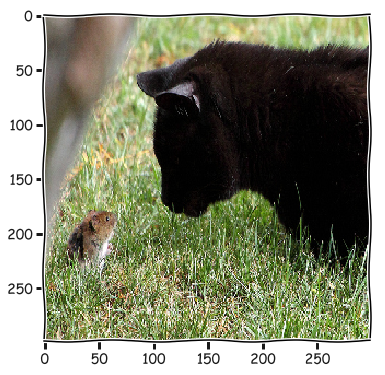

In [17]:
# Download InceptionV3 network 
inet_model = inc_net.InceptionV3()

# Image transforming function
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

images = transform_img_fn(['../data/cat_mouse.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
with plt.xkcd():
    fig,ax = plt.subplots(figsize=(8,6))
    ax.imshow(images[0] / 2 + 0.5)
    
# Get predictions 
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)
    
# Fit LIME explainer (Takes about 1.5 mins to run)
iexplainer = lime_image.LimeImageExplainer()
explanation = iexplainer.explain_instance(images[0], inet_model.predict, top_labels=5, num_samples=1000)

### Resulting image explaination

In this explaination the green parts contribute to the chosen class, while the red parts contribute to a different class than the chosen one.

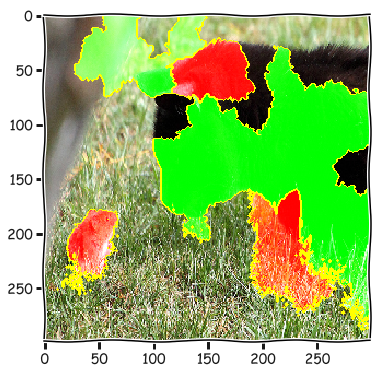

In [18]:
# Plot result 
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
with plt.xkcd():
    fig,ax = plt.subplots(figsize=(8,6))
    ax.imshow(mark_boundaries(temp / 2 + 0.5, mask));

## Text Example: 

- We will cover the text example we touched on in the presentation (which is also in the [LIME tutorial](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Lime%20-%20basic%20usage%2C%20two%20class%20case.ipynb) we used for this section)

This example shows a model that looks good initially. It has a high accuracy and F1 score, but when we look under the hood the model is picking up on the wrong signals.  It is looking at .edu domains and hosting information to determine is the content is atheist or Christian, instead of the actual content of the email. Interperatability is especially useful in finding models with undesirable behavior, like this one!  

In [19]:
# Load data
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

# Transform data
vectorizer = TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

# Train model
rf_text = RandomForestClassifier(n_estimators=500)
rf_text.fit(train_vectors, newsgroups_train.target)

pred = rf_text.predict(test_vectors)
print(f'Model F1 Score: {round(f1_score(newsgroups_test.target, pred, average="binary"),4)}')
print(f'Model Accuracy: {round(accuracy_score(newsgroups_test.target, pred),4)}')
print()

# Make pipeline and explainer 
c = make_pipeline(vectorizer, rf_text)
texplainer = LimeTextExplainer(class_names=class_names)

# Warning filter for older lime internals 
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    
    # Get explaination
    idx = 83
    exp = texplainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
    print('Document id: %d' % idx)
    print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
    print('True class: %s' % class_names[newsgroups_test.target[idx]])
    exp.show_in_notebook()

Model F1 Score: 0.9242
Model Accuracy: 0.9093

Document id: 83
Probability(christian) = 0.44
True class: atheism


<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Fairness Section

### Census Income dataset

The previous dataset was thorough and complex enough to demonstrate interpretability techniques, but as it is an anonymized dataset, it has little to no information on sensitive features. We will switch to another dataset for this part that is more suited to analyzing fairness techniques, as it possesses information on gender and race. 

This dataset is called the **Census Income dataset**, and it associates features of working adults to **whether or not they make more than $50k/yr**. It is extracted from the 1994 Census database, and contains **48842 observations** with a mix of continuous and categorical features (14 in total).  

List of features:
- **age:** continuous. 
- **workclass:** categorical. 
- **education:** categorical. 
- **education-num:** continuous. 
- **marital-status:** categorical. 
- **relationship:** categorical. 
- **race:** categorical. 
- **sex:** categorical. 
- **capital-gain:** continuous. 
- **capital-loss:** continuous. 
- **hours-per-week:** continuous. 
- **fnlwgt:** (final weight) continuous. 
- **native-country:** categorical.

Response: binary, corresponding to >50K (1) or <=50K (0). 


#### Reference:
Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996
